## 1. Імпорт бібліотек та підготовка середовища

In [11]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import nltk 
import re 
import json 
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Завантаження стоп-слів
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Завантаження та підготовка даних

In [12]:
print("Loading Yelp review data...")

yelp_data_path = "../input/yelp-dataset/yelp_academic_dataset_review.json"
raw_reviews = []

with open(yelp_data_path, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        raw_reviews.append(json.loads(line))
        if i >= 50000:  # обмежимо для швидкості
            break

df = pd.DataFrame(raw_reviews)
print(f"Successfully loaded {len(df)} entries.")
df.head()


Loading Yelp review data...
Successfully loaded 50001 entries.


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


## 3. Попередня обробка текстів

In [13]:
print("Cleaning and preprocessing review content...")

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['clean_text'] = df['text'].apply(preprocess_text)
print("Text preprocessing complete.")

# Бінарна мітка (1 — позитив, 0 — негатив)
df['label'] = df['stars'].apply(lambda x: 1 if x > 3 else 0)
df[['text', 'clean_text', 'stars', 'label']].head()


Cleaning and preprocessing review content...
Text preprocessing complete.


,text,clean_text,stars,label
0,"If you decide to eat here, just be aware it is...",decide eat aware going take 2 hours beginning ...,3.0,0
1,I've taken a lot of spin classes over the year...,taken lot spin classes years nothing compares ...,5.0,1
2,Family diner. Had the buffet. Eclectic assortm...,family diner buffet eclectic assortment large ...,3.0,0
3,"Wow! Yummy, different, delicious. Our favo...",wow yummy different delicious favorite lamb cu...,5.0,1
4,Cute interior and owner (?) gave us tour of up...,cute interior owner gave us tour upcoming pati...,4.0,1


## 4. Розбиття даних на train/test

In [14]:
print("Splitting dataset into training and test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42
)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Splitting dataset into training and test sets...
Train size: 40000, Test size: 10001


## 5. Токенізація та паддінг

In [15]:
print("Tokenizing text...")

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

sequence_length = 100
X_train_pad = pad_sequences(train_sequences, maxlen=sequence_length, padding='post')
X_test_pad = pad_sequences(test_sequences, maxlen=sequence_length, padding='post')

y_train = np.array(y_train)
y_test = np.array(y_test)

print("Tokenization and padding completed.")
print(f"Train shape: {X_train_pad.shape}, Test shape: {X_test_pad.shape}")


Tokenizing text...
Tokenization and padding completed.
Train shape: (40000, 100), Test shape: (10001, 100)


## 6. Побудова та навчання LSTM моделі

In [16]:
print("Constructing LSTM model...")

model = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

print("Training the model...")
history = model.fit(
    X_train_pad, y_train,
    epochs=6,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    verbose=1
)


Constructing LSTM model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.7044 - loss: 0.5951 - val_accuracy: 0.8366 - val_loss: 0.4624
Epoch 2/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8131 - loss: 0.4665 - val_accuracy: 0.8404 - val_loss: 0.3422
Epoch 3/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8855 - loss: 0.2956 - val_accuracy: 0.8825 - val_loss: 0.2917
Epoch 4/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9045 - loss: 0.2539 - val_accuracy: 0.7946 - val_loss: 0.4659
Epoch 5/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8660 - loss: 0.3329 - val_accuracy: 0.8763 - val_loss: 0.3087
Epoch 6/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9267 - loss: 0.2091 - val_accuracy: 0.8777 - val_loss: 0.3091


## 7. Оцінка моделі та метрики

Evaluating model on test data...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Evaluation Metrics:
Accuracy : 0.8777
Precision: 0.8787
Recall   : 0.9569
F1-score : 0.9161

Classification report:
              precision    recall  f1-score   support

    Negative       0.87      0.69      0.77      3022
    Positive       0.88      0.96      0.92      6979

    accuracy                           0.88     10001
   macro avg       0.88      0.83      0.85     10001
weighted avg       0.88      0.88      0.87     10001



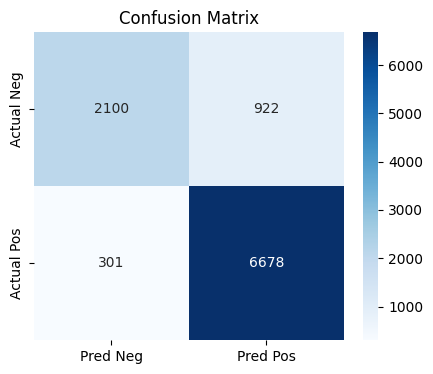

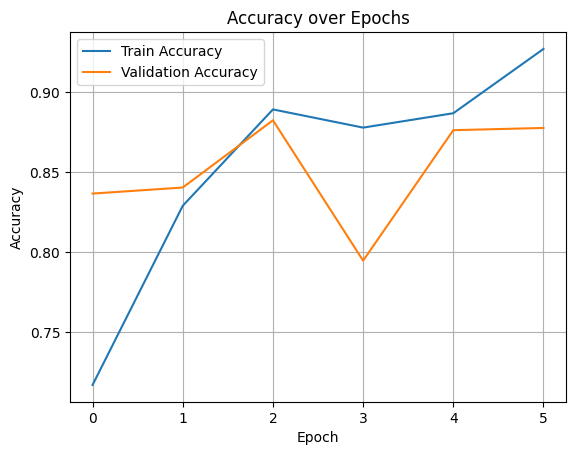

In [17]:
print("Evaluating model on test data...")

y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nEvaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Матриця помилок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Neg','Pred Pos'],
            yticklabels=['Actual Neg','Actual Pos'])
plt.title('Confusion Matrix')
plt.show()

# Графік точності
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## 8. Тестування моделі на прикладах

In [18]:
def analyze_sentiment(input_text):
    cleaned = preprocess_text(input_text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=sequence_length, padding='post')
    prob = model.predict(padded)[0][0]
    return "Positive" if prob > 0.5 else "Negative"

print("\nSample prediction tests:")
examples = [
    "Absolutely loved the atmosphere and the food was fantastic!",
    "I had to wait forever and the service was terrible.",
    "Not bad, but a bit expensive.",
    "Amazing experience, highly recommend!",
    "Worst coffee ever, never coming back."
]
for ex in examples:
    print(f"Review: {ex}\nSentiment: {analyze_sentiment(ex)}\n")



Sample prediction tests:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Review: Absolutely loved the atmosphere and the food was fantastic!
Sentiment: Positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Review: I had to wait forever and the service was terrible.
Sentiment: Negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Review: Not bad, but a bit expensive.
Sentiment: Negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Review: Amazing experience, highly recommend!
Sentiment: Positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Review: Worst coffee ever, never coming back.
Sentiment: Negative



## 9. Порівняння різних методів токенізації

In [19]:
from transformers import BertTokenizerFast
import spacy

# --- "BERT-like" Tokenizer (safe local version) ---
print("Testing simulated BERT Tokenizer...")

tokenizer_bert_like = Tokenizer(num_words=30000, lower=True, oov_token="[UNK]")
tokenizer_bert_like.fit_on_texts(X_train)

X_train_bert_like = pad_sequences(
    tokenizer_bert_like.texts_to_sequences(X_train),
    maxlen=sequence_length,
    padding='post'
)
X_test_bert_like = pad_sequences(
    tokenizer_bert_like.texts_to_sequences(X_test),
    maxlen=sequence_length,
    padding='post'
)

model_bert_like = Sequential([
    Embedding(input_dim=30000, output_dim=128),
    LSTM(128),
    Dense(1, activation='sigmoid')
])
model_bert_like.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bert_like.fit(X_train_bert_like, y_train, epochs=3, batch_size=64, validation_split=0.1, verbose=1)

y_pred_bert_like = (model_bert_like.predict(X_test_bert_like) > 0.5).astype(int)
bert_like_acc = accuracy_score(y_test, y_pred_bert_like)
bert_like_f1 = f1_score(y_test, y_pred_bert_like)

# --- spaCy Tokenizer ---
print("Testing spaCy Tokenizer (fast mode)...")

import spacy
nlp = spacy.blank("en")

def spacy_tokenize_fast(text):
    return " ".join([t.text for t in nlp(text)])

train_subset = df.sample(5000, random_state=42)
test_subset = df.sample(1000, random_state=21)

X_train_spacy = train_subset['clean_text'].apply(spacy_tokenize_fast)
X_test_spacy = test_subset['clean_text'].apply(spacy_tokenize_fast)

y_train_spacy = train_subset['label'].values
y_test_spacy = test_subset['label'].values

tokenizer_spacy = Tokenizer(num_words=10000)
tokenizer_spacy.fit_on_texts(X_train_spacy)

X_train_spacy_seq = pad_sequences(tokenizer_spacy.texts_to_sequences(X_train_spacy), maxlen=sequence_length)
X_test_spacy_seq = pad_sequences(tokenizer_spacy.texts_to_sequences(X_test_spacy), maxlen=sequence_length)

model_spacy = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    LSTM(128),
    Dense(1, activation='sigmoid')
])
model_spacy.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_spacy.fit(X_train_spacy_seq, y_train_spacy, epochs=3, batch_size=64, validation_split=0.1, verbose=1)

y_pred_spacy = (model_spacy.predict(X_test_spacy_seq) > 0.5).astype(int)
spacy_acc = accuracy_score(y_test_spacy, y_pred_spacy)
spacy_f1 = f1_score(y_test_spacy, y_pred_spacy)

# --- Порівняння ---
comparison = pd.DataFrame({
    'Tokenizer': ['Keras', 'BERT', 'spaCy'],
    'Accuracy': [acc, bert_like_acc, spacy_acc],
    'F1-score': [f1, bert_like_f1, spacy_f1]
})

print("\nTokenizer Comparison Results:")
display(comparison)


Testing simulated BERT Tokenizer...
Epoch 1/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7121 - loss: 0.5988 - val_accuracy: 0.7492 - val_loss: 0.5529
Epoch 2/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7294 - loss: 0.5748 - val_accuracy: 0.7218 - val_loss: 0.5863
Epoch 3/3
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7637 - loss: 0.5106 - val_accuracy: 0.8735 - val_loss: 0.3072
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Testing spaCy Tokenizer (fast mode)...
Epoch 1/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7087 - loss: 0.5957 - val_accuracy: 0.8420 - val_loss: 0.3694
Epoch 2/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9062 - loss: 0.2440 - val_accuracy: 0.8540 - val_loss: 0.3505
Epoch 3/3
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9574 - loss: 0.1259 - val_accuracy: 0.8640 - val_loss: 0.4193
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Tokenizer Comparison Results:


,Tokenizer,Accuracy,F1-score
0,Keras,0.877712,0.916112
1,BERT,0.879812,0.915602
2,spaCy,0.876000,0.914008
